# Kuramoto Tests

In [1]:
import numpy as np
import matplotlib.pylab as plt
import networkx as nx
from NetworkFunctions import *
from NetworkClasses import *

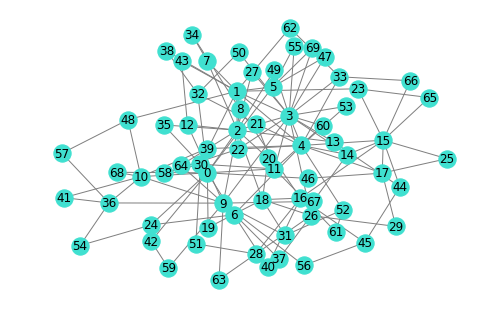

In [2]:
N = 70; # number of nodes
m = 2;
G = nx.barabasi_albert_graph(N,m,seed=None); # Barabasi-Albert graph

A = nx.to_numpy_matrix(G); # creates adjacency matrix

w = np.random.uniform(-2, 2, N); # defines natural frequencies
K = .5 # coupling constant
alpha = 1 # SL parameter

F = np.zeros(N)
for i in range(int(N/5)):
    F[5*i] = 1
Omega = np.pi

# initial conditions
theta0 = np.random.uniform(0, 2*np.pi, N)

nx.draw(G, node_color='turquoise', edge_color='grey', with_labels=True)
plt.show()


## The Kuramoto Model

The equations for a (forced) complex network of $N$ Kuramoto oscillators with natural frequencies $\omega_k$, adjacency matrix $A$, coupling strength (or average coupling strength, for the case where $A$ is weighted) $\lambda$ and a forced term of type $ F_i \cos{(\Omega t - \theta)} $ that acts on a fraction $f = N_F/N$, where $N_F$ is the number of forced oscillators (nonzero $F$), can be written as:

$$ \dot{\theta}_i = \omega_i + \lambda \sum_{j=1}^N A_{ij} \sin{(\theta_j - \theta_i)} + F_i \sin{(\Omega t - \theta_i)} $$

which gives the Jacobian:

$$ J_{ij} = \frac{\partial \dot{\theta}_i}{\partial \theta_j} = A_{ij} \cos{(\theta_j - \theta_i)} - \delta_{ij} F_i \cos{(\Omega t - \theta_i)} $$

If we measure the phase from a reference frame rotating with the forced frequency $\Omega$, i.e., make the change of variables $\phi_i = \theta_i - \Omega t$, we find:

$$ \dot{\phi}_i = \omega_i - \Omega + \lambda \sum_{j=1}^N A_{ij} \sin{(\phi_j - \phi_i)} - F_i \sin{(\phi_i)} $$

with Jacobian:

$$ J_{ij} = \frac{\partial \dot{\phi}_i}{\partial \phi_j} = A_{ij} \cos{(\phi_j - \phi_i)} - \delta_{ij} F_i \cos{(\phi_i)} $$

## 1. Simple Kuramoto

In [3]:
kuramoto = KuramotoNetwork(w, A, K)
Kforced = KuramotoNetwork(w, A, K, F, Omega)

In [4]:
%%time
t = np.arange(0,50,.2)
theta, _ = kuramoto.integrate(theta0, t)
theta_f, _ = Kforced.integrate(theta0, t)

CPU times: user 10.1 s, sys: 67.4 ms, total: 10.1 s
Wall time: 11.2 s


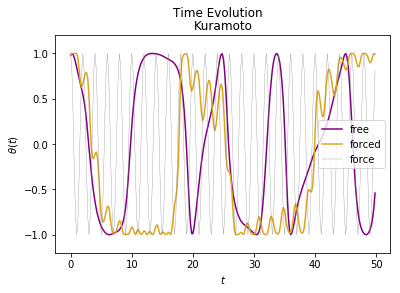

In [5]:
osc=5
fig, ax2 = plt.subplots(1,1)

fig.suptitle('Time Evolution')

ax2.set_title('Kuramoto')
ax2.set_xlabel('$t$')
ax2.set_ylabel(r'$\theta(t)$')
ax2.set_ylim([-1.2, 1.2])

ax2.plot(t, np.cos(theta[i*osc]), label='free', color='purple')
ax2.plot(t, np.cos(theta_f[i*osc]), label='forced', color='goldenrod')
ax2.plot(t, F[osc]*np.cos(Omega*t), label='force', color='grey', linewidth='.3')
ax2.legend()

plt.show()

### Order Parameter

For a network of N oscillators with phase $\theta_i$, we can measure the system's synchronization with:

$$ \mathrm{z}(t) = r(t) e^{i \psi(t)} = \frac{1}{N} \sum_{j=1}^N e^{i \theta_j(t)} $$

The real part $r$ is called order parameter, whereas $\psi$ is the mean phase of the system. When the system is not synchronized, $r \approx 0$, whereas global synchronization is said to be achieved when $r \to 1$.

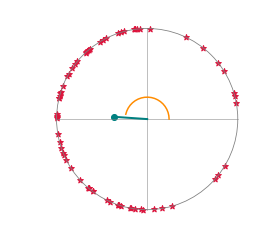

In [6]:
fig = plt.figure()

ax = fig.add_subplot(111)

ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_aspect('equal')
ax.axis('off')

# Plots points corresponding to the oscillators' phase positions at time t
ax.scatter(np.cos(theta[:,200]), y = np.sin(theta[:,200]), marker = '*', color='crimson')

# Finds the order parameter at the time instant t
thetaT = np.transpose(theta)
order_par = sum(np.exp(thetaT[200]*1j))/N
r = np.absolute(order_par)
psi = np.angle(order_par)

# Plots horizontal and vertical diameters of the circle
ax.plot([-1, 1], [0, 0], linewidth = '.5', color = 'grey')
ax.plot([0, 0], [-1, 1], linewidth = '.5', color = 'grey')

#Plots unit circle
circle = plt.Circle((0,0), radius = 1.0, linewidth = '0.8', color = 'grey', fill = False)
ax.add_patch(circle)

#Plots order parameter line
ax.plot([0, r*np.cos(psi)], [0, r*np.sin(psi)], linewidth = '2.0', color = 'teal')
ax.scatter(r*np.cos(psi), r*np.sin(psi), marker='o', color='teal')

# Shows mean phase
s = np.arange(0,1,0.05)
if r>0.4:
    ax.plot(0.25*np.cos(psi*s), 0.25*np.sin(psi*s), color='darkorange')
else:
    ax.plot((2*r/3)*np.cos(psi*s), (2*r/3)*np.sin(psi*s), color='darkorange')

plt.show()

### Average in time

In practice, we actually calculate the mean value of $r$ and $psi$ (as well as their standard deviation) over a time interval $[t_0, t_0 + \Delta t]$ corresponding to at least one full oscillation period of the system so one can be sure our data is statistically relevant and time fluctuations are accounted for:

$$ \langle r \rangle = \frac{1}{\Delta t} \int_{t_0}^{t_0+\Delta t} r(t) dt $$

since we find the time evolution of the phase through numerical integration already, the integral above is performed as a Riemmann sum of the numerically obtained values. We also find it's useful to computate the angular velocity $\dot{\psi} = \frac{d \psi}{dt}$ of the mean phase, for it produces more insights on the colective dyamical behavior of the system.

We may then calculate such parameters for a range of different coupling constants $\lambda$ the  to see how the synchronization behavior is affected.

In [7]:
%%time
sync_par = OrderParameter(kuramoto, theta0, 40, 50, 0.1, Kf=3)

CPU times: user 8min 31s, sys: 6.15 s, total: 8min 37s
Wall time: 5min 21s


In [8]:
K = sync_par['K']
r = sync_par['r']
r_std = sync_par['r_std']
psi = sync_par['psi']
psi_std = sync_par['psi_std']
psidot = sync_par['psidot']
psidot_std = sync_par['psidot_std']

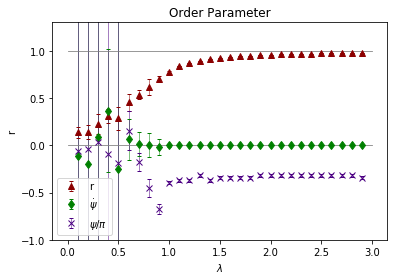

In [9]:
fig, ax1 = plt.subplots(1, 1)

ax1.set_title("Order Parameter")
ax1.set_ylabel("r")
ax1.set_xlabel(r'$\lambda$')
ax1.set_ylim(-1,1.3)

ax1.errorbar(K ,r, yerr=r_std, marker='^', color = 'darkred', fmt='o', elinewidth=.5, \
             capsize=2, label='r')
ax1.errorbar(K ,psidot, yerr=psidot_std, marker='d', color = 'g', fmt='o', elinewidth=.5, \
             capsize=2, label=r'$\dot{\psi}$')
ax1.errorbar(K ,psi/np.pi, yerr=psi_std, marker='x', color = 'indigo', fmt='o', \
             elinewidth=.5, capsize=2, label=r'$\psi / \pi$')

ax1.plot([0, 3], [1, 1], linewidth = .8, color = 'grey')
ax1.plot([0, 3], [0, 0], linewidth = .8, color = 'grey')

ax1.legend()
plt.show()

### Average in initial states

To assure statistical relevance, what may also be done is to find such parameters for a set with several different initial conditions and then take the average. This way, there can be certainty on the fact that the main dynamical properties of the systems indeed depends on the network itself, not relying on any specific initial configuration. We define the standard deviation $\sigma^{(r)}_{z_0}$ of $r$ in the initial conditions as:

$$ \sigma^{(r)}_{z_0} = \langle \ \langle r + \sigma^{(r)}_t \rangle_t + \langle r \rangle_t \ \rangle_{z0} $$

where $\langle \rangle_t$ is the time average, $\sigma^{(r)}_t$ the standard deviation with respect to time (both for a single initial condition $z_0$), and $\langle \rangle_{z_0}$ the average through all initial states $z_0$. It's worth to remark that we mantain $0.1 < \rho_0 < 0.9$ in the Stuart-Landau case, as for larger values of $\rho$ the system may fall into one of its attractors, which is not the situation we desire to analyze.

In [10]:
%%time
sync_par_av = AverageOrderPar(kuramoto, 3, 40, 45, .1, dt=0.2, Kf=2, dK=.2)

CPU times: user 5min 17s, sys: 4.34 s, total: 5min 21s
Wall time: 3min 37s


In [11]:
K_av = sync_par_av['K']
r_av = sync_par_av['r']
r_std_av = sync_par_av['r_std']
psi_av = sync_par_av['psi']
psi_std_av = sync_par_av['psi_std']
psidot_av = sync_par_av['psidot']
psidot_std_av = sync_par_av['psidot_std']

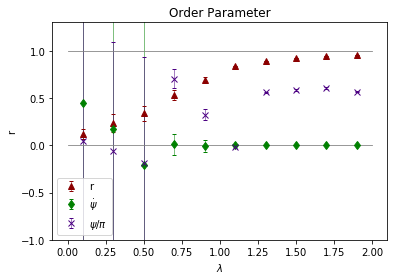

In [12]:
fig, ax1 = plt.subplots(1, 1)

ax1.set_title("Order Parameter")
ax1.set_ylabel("r")
ax1.set_xlabel(r'$\lambda$')
ax1.set_ylim(-1,1.3)

ax1.errorbar(K_av ,r_av, yerr=r_std_av, marker='^', color = 'darkred', fmt='o', elinewidth=.5, \
             capsize=2, label='r')
ax1.errorbar(K_av ,psidot_av, yerr=psidot_std_av, marker='d', color = 'g', fmt='o', elinewidth=.5, \
             capsize=2, label=r'$\dot{\psi}$')
ax1.errorbar(K_av ,psi_av/np.pi, yerr=psi_std_av, marker='x', color = 'indigo', fmt='o', \
             elinewidth=.5, capsize=2, label=r'$\psi / \pi$')

ax1.plot([0, 2], [1, 1], linewidth = .8, color = 'grey')
ax1.plot([0, 2], [0, 0], linewidth = .8, color = 'grey')

ax1.legend()
plt.show()

## 2. Forced Kuramoto: rotating reference frame

In [13]:
K = .5
kur_forced = KuramotoNetwork(w, A, K, F, Omega, rot_frame=True)

In [14]:
%%time
t = np.arange(0,50,.2)
phi, _ = kur_forced.integrate(theta0, t)

CPU times: user 4.94 s, sys: 11.6 ms, total: 4.95 s
Wall time: 5.03 s


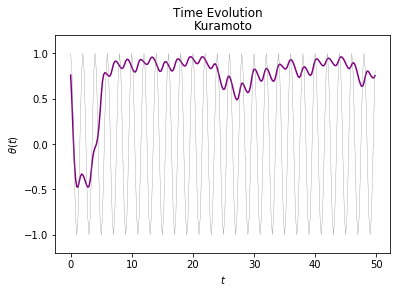

In [15]:
osc=5
fig, ax2 = plt.subplots(1,1)

fig.suptitle('Time Evolution')

ax2.set_title('Kuramoto')
ax2.set_xlabel('$t$')
ax2.set_ylabel(r'$\theta(t)$')
ax2.set_ylim([-1.2, 1.2])

ax2.plot(t, np.cos(phi[osc]), color='purple')
ax2.plot(t, F[osc]*np.cos(Omega*t), color='grey', linewidth='.3')

plt.show()

### Order Parameter

$$ \mathrm{z}(t) = r(t) e^{i \psi(t)} = \frac{1}{N} \sum_{j=1}^N e^{i \theta_j(t)} $$

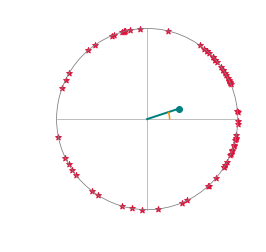

In [16]:
fig = plt.figure()

ax = fig.add_subplot(111)

ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_aspect('equal')
ax.axis('off')

# Plots points corresponding to the oscillators' phase positions at time t
ax.scatter(np.cos(phi[:,200]), y = np.sin(phi[:,200]), marker = '*', color='crimson')

# Finds the order parameter at the time instant t
thetaT = np.transpose(phi)
order_par = sum(np.exp(thetaT[200]*1j))/N
r = np.absolute(order_par)
psi = np.angle(order_par)

# Plots horizontal and vertical diameters of the circle
ax.plot([-1, 1], [0, 0], linewidth = '.5', color = 'grey')
ax.plot([0, 0], [-1, 1], linewidth = '.5', color = 'grey')

#Plots unit circle
circle = plt.Circle((0,0), radius = 1.0, linewidth = '0.8', color = 'grey', fill = False)
ax.add_patch(circle)

#Plots order parameter line
ax.plot([0, r*np.cos(psi)], [0, r*np.sin(psi)], linewidth = '2.0', color = 'teal')
ax.scatter(r*np.cos(psi), r*np.sin(psi), marker='o', color='teal')

# Shows mean phase
s = np.arange(0,1,0.05)
if r>0.4:
    ax.plot(0.25*np.cos(psi*s), 0.25*np.sin(psi*s), color='darkorange')
else:
    ax.plot((2*r/3)*np.cos(psi*s), (2*r/3)*np.sin(psi*s), color='darkorange')

plt.show()

### Average in time

$$ \langle r \rangle = \frac{1}{\Delta t} \int_{t_0}^{t_0+\Delta t} r(t) dt $$

In [17]:
%%time
sync_par = OrderParameter(kur_forced, theta0, 40, 45, 0.1, Kf=3)

CPU times: user 7min 37s, sys: 9.9 s, total: 7min 47s
Wall time: 5min 50s


In [18]:
K = sync_par['K']
r = sync_par['r']
r_std = sync_par['r_std']
psi = sync_par['psi']
psi_std = sync_par['psi_std']
psidot = sync_par['psidot']
psidot_std = sync_par['psidot_std']

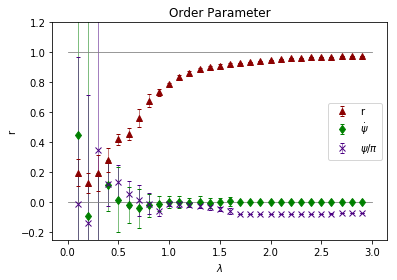

In [23]:
fig, ax1 = plt.subplots(1, 1)

ax1.set_title("Order Parameter")
ax1.set_ylabel("r")
ax1.set_xlabel(r'$\lambda$')
ax1.set_ylim(-.25,1.2)

ax1.errorbar(K ,r, yerr=r_std, marker='^', color = 'darkred', fmt='o', elinewidth=.5, \
             capsize=2, label='r')
ax1.errorbar(K ,psidot, yerr=psidot_std, marker='d', color = 'g', fmt='o', elinewidth=.5, \
             capsize=2, label=r'$\dot{\psi}$')
ax1.errorbar(K ,psi/np.pi, yerr=psi_std, marker='x', color = 'indigo', fmt='o', \
             elinewidth=.5, capsize=2, label=r'$\psi / \pi$')

ax1.plot([0, 3], [1, 1], linewidth = .8, color = 'grey')
ax1.plot([0, 3], [0, 0], linewidth = .8, color = 'grey')

ax1.legend()
plt.show()

### Average in initial states

$$ \sigma^{(r)}_{z_0} = \langle \ \langle r + \sigma^{(r)}_t \rangle_t + \langle r \rangle_t \ \rangle_{z0} $$

In [20]:
%%time
sync_par_av = AverageOrderPar(kur_forced, 5, 40, 45, .1, dt=.2, Kf=2, dK=.2)

CPU times: user 7min 48s, sys: 5.27 s, total: 7min 53s
Wall time: 6min 59s


In [21]:
K_av = sync_par_av['K']
r_av = sync_par_av['r']
r_std_av = sync_par_av['r_std']
psi_av = sync_par_av['psi']
psi_std_av = sync_par_av['psi_std']
psidot_av = sync_par_av['psidot']
psidot_std_av = sync_par_av['psidot_std']

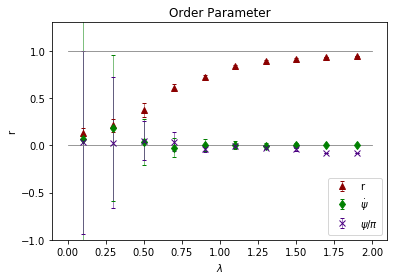

In [24]:
fig, ax1 = plt.subplots(1, 1)

ax1.set_title("Order Parameter")
ax1.set_ylabel("r")
ax1.set_xlabel(r'$\lambda$')
ax1.set_ylim(-1,1.3)

ax1.errorbar(K_av ,r_av, yerr=r_std_av, marker='^', color = 'darkred', fmt='o', elinewidth=.5, \
             capsize=2, label='r')
ax1.errorbar(K_av ,psidot_av, yerr=psidot_std_av, marker='d', color = 'g', fmt='o', elinewidth=.5, \
             capsize=2, label=r'$\dot{\psi}$')
ax1.errorbar(K_av ,psi_av/np.pi, yerr=psi_std_av, marker='x', color = 'indigo', fmt='o', \
             elinewidth=.5, capsize=2, label=r'$\psi / \pi$')

ax1.plot([0, 2], [1, 1], linewidth = .8, color = 'grey')
ax1.plot([0, 2], [0, 0], linewidth = .8, color = 'grey')

ax1.legend()
plt.show()